# PHM Data Challenge 2008 : Remaining Useful Lifetime Estimation from Sensor Data

## Matthew Jacobsen
## May 11, 2021

### Introduction:

Amidst many potential uses for machine learning algorithms, data scientists are often interested in the ability to make **predictions** about when events will happen.  These predictions can range from weather to hardware failures, as can be found in multiple online data challenges for community members to undertake.  One of these challenges, from 2008, was posted by NASA and GE and focuses on the use of sensor data from jet propulsion engines to predict the remaining useful life of the engine itself.  

In this challenge, NASA and GE put out a set of training and test data containing unit identifiers, three parameters defining the operational mode of the engine, and sensor data for 21 embedded sensors over multiple operating cycles. In this walkthrough, we will explore the construction of a model for predicting the remaining useful life of the engines with this data.  

Some of what we'll go through is based upon my personal approach to modelling systems, which tends to stay on the conservative side.  Often, my approach is to chose the simplest possible model to start from.  You can always make the model more complex as needed, but simpler models are often better to start and can give you more direct insights into system behavior.  So with that, let's dive in.

### Loading Packages and Data

Let's start by loading in our data and packages for use.  We'll load the data in as if it were a csv file.  Since there are no textual delimiters other than spaces, we'll let Pandas know that, as well as defining useful header names.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
import seaborn as sns
from mlxtend.plotting import scatterplotmatrix as spm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
import itertools

os.chdir(r'C:\Users\jacob\Desktop\Challenge_Data')

In [2]:
df_train = pd.read_csv('train.txt', header=None, delimiter=r"\s+")
df_train.columns = [
    'Unit Number',
    'Time in Cycles',
    'OS1',
    'OS2',
    'OS3',
    'SM1',
    'SM2',
    'SM3',
    'SM4',
    'SM5',
    'SM6',
    'SM7',
    'SM8',
    'SM9',
    'SM10',
    'SM11',
    'SM12',
    'SM13',
    'SM14',
    'SM15',
    'SM16',
    'SM17',
    'SM18',
    'SM19',
    'SM20',
    'SM21'
]
df_train.head()

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM12,SM13,SM14,SM15,SM16,SM17,SM18,SM19,SM20,SM21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


In [3]:
df_test = pd.read_csv('test.txt', header=None, delimiter=r"\s+")
df_test.columns = [
    'Unit Number',
    'Time in Cycles',
    'OS1',
    'OS2',
    'OS3',
    'SM1',
    'SM2',
    'SM3',
    'SM4',
    'SM5',
    'SM6',
    'SM7',
    'SM8',
    'SM9',
    'SM10',
    'SM11',
    'SM12',
    'SM13',
    'SM14',
    'SM15',
    'SM16',
    'SM17',
    'SM18',
    'SM19',
    'SM20',
    'SM21'
]
df_test.head()

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM12,SM13,SM14,SM15,SM16,SM17,SM18,SM19,SM20,SM21
0,1,1,0.0016,0.0002,100.0,518.67,642.88,1587.21,1412.44,14.62,...,521.44,2388.10,8124.04,8.4363,0.03,393,2388,100.00,38.97,23.3029
1,1,2,24.9993,0.6215,80.0,462.54,536.45,1262.64,1055.44,7.05,...,164.32,2027.95,7865.20,10.8935,0.02,308,1915,84.93,14.29,8.6686
2,1,3,0.0004,0.0000,100.0,518.67,642.65,1589.75,1409.54,14.62,...,521.15,2388.19,8121.12,8.4620,0.03,393,2388,100.00,38.91,23.2693
3,1,4,10.0034,0.2500,20.0,489.05,604.44,1499.93,1315.34,10.52,...,371.42,2388.21,8123.53,8.6815,0.03,369,2319,100.00,28.60,17.0930
4,1,5,0.0024,0.0011,100.0,518.67,642.74,1585.47,1408.12,14.62,...,520.86,2388.13,8118.30,8.4617,0.03,392,2388,100.00,38.82,23.3124


### Quality Checking Training Data

Next, we'll check the data for any missing data, as well as outputting the maximum number of cycles associated with each engine.  This will give us some idea what we are dealing with. 

In [4]:
unique_units = df_train['Unit Number'].unique()

output_df = []

for uu in unique_units:
    sub_df = df_train[df_train['Unit Number']==uu] 
    max_cycles = sub_df['Time in Cycles'].max()
    cols = list(sub_df.columns)
    nan_flag = False
    for col in cols:
        if len(sub_df[sub_df[col].isna()]) > 0:
            missing_data += len(sub_df[sub_df[col]].isna())
            nan_flag = True
    if nan_flag == False:
        sub_list = [uu, 0, max_cycles]
    else:
        sub_list = [uu, missing_data, max_cycles]
    output_df.append(sub_list)

output_df

[[1, 0, 223],
 [2, 0, 164],
 [3, 0, 150],
 [4, 0, 159],
 [5, 0, 357],
 [6, 0, 225],
 [7, 0, 168],
 [8, 0, 276],
 [9, 0, 181],
 [10, 0, 228],
 [11, 0, 210],
 [12, 0, 242],
 [13, 0, 210],
 [14, 0, 147],
 [15, 0, 178],
 [16, 0, 172],
 [17, 0, 228],
 [18, 0, 196],
 [19, 0, 167],
 [20, 0, 154],
 [21, 0, 205],
 [22, 0, 203],
 [23, 0, 213],
 [24, 0, 191],
 [25, 0, 281],
 [26, 0, 210],
 [27, 0, 178],
 [28, 0, 278],
 [29, 0, 228],
 [30, 0, 200],
 [31, 0, 283],
 [32, 0, 193],
 [33, 0, 286],
 [34, 0, 286],
 [35, 0, 188],
 [36, 0, 147],
 [37, 0, 177],
 [38, 0, 287],
 [39, 0, 161],
 [40, 0, 187],
 [41, 0, 201],
 [42, 0, 241],
 [43, 0, 209],
 [44, 0, 233],
 [45, 0, 242],
 [46, 0, 277],
 [47, 0, 227],
 [48, 0, 227],
 [49, 0, 285],
 [50, 0, 223],
 [51, 0, 182],
 [52, 0, 212],
 [53, 0, 259],
 [54, 0, 249],
 [55, 0, 147],
 [56, 0, 162],
 [57, 0, 150],
 [58, 0, 147],
 [59, 0, 169],
 [60, 0, 300],
 [61, 0, 229],
 [62, 0, 238],
 [63, 0, 254],
 [64, 0, 154],
 [65, 0, 209],
 [66, 0, 190],
 [67, 0, 145],
 [68

This is good! We don't have any missing (NA or NAN) data for any of the engines.  However, we have a high degree of variation in the number of cycles of data that we have available.  This may cause an issue for our modelling later, because the variation can introduce noise that will make model building more difficult or introduce error.

To better see this variation, let's look at a box plot of the maximum number of cycles.

<AxesSubplot:>

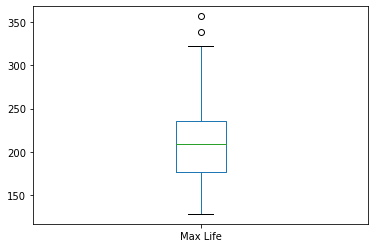

In [5]:
cycles_total = []
for unit in unique_units:
    cycles_total.append(df_train[df_train['Unit Number']==unit]['Time in Cycles'].max())

plot_df = pd.DataFrame(cycles_total, columns=['Max Life'])
plot_df.plot(kind='box',y='Max Life')

Now it's more clear that we have a large spread with a few statistical outliers in the data.  We'll have to keep this in mind for later on.

### Converting Cycles to account for variable "starting condition"

For now, since we know that the maximum cycle number should correspond to failure of that unit, we'll convert the cycles to start from negative numbers, which will make 0 our failure point.  

In [6]:
max_cycles_train = {x:df_train[df_train['Unit Number']==x]['Time in Cycles'].max() for x in df_train['Unit Number'].unique()}
max_cycles_test = {x:df_test[df_test['Unit Number']==x]['Time in Cycles'].max() for x in df_test['Unit Number'].unique()}

df_train['MaxCycles'] = df_train['Unit Number'].apply(lambda x: max_cycles_train[x])
df_test['MaxCycles'] = df_train['Unit Number'].apply(lambda x: max_cycles_train[x])
df_train['RevCycles'] = df_train['Time in Cycles'] - df_train['MaxCycles']
df_test['RevCycles'] = df_test['Time in Cycles'] - df_test['MaxCycles']

df_train.head()

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM14,SM15,SM16,SM17,SM18,SM19,SM20,SM21,MaxCycles,RevCycles
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735,223,-222
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619,223,-221
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555,223,-220
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832,223,-219
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025,223,-218


### Exploring Sensor and Operations Data

Now that we've taken (at least temporarily) of the cycles issue, let's look at our operations mode and sensor data.  Starting with the Operations Mode data, we can look at the variation with cycles.

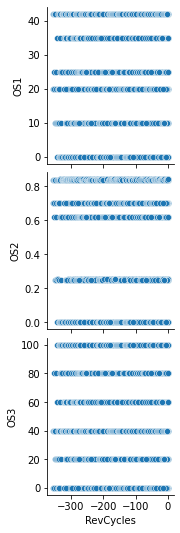

In [7]:
pp = sns.pairplot(
    data=df_train,
    x_vars = ['RevCycles'],
    y_vars = [x for x in df_train.columns if ('OS' in x)],
    diag_kind = None
)

This is interesting.  OS1 shows no variation at all with the cycle, whereas OS2 and OS3 look very clustered and well separated from each other.  Let's 3D plot this to see if our clustering holds more broadly. 

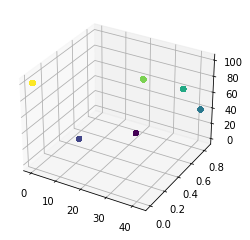

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = df_train['OS1']
ydata = df_train['OS2']
zdata = df_train['OS3']
ax.scatter3D(xdata,ydata,zdata,c=zdata, cmap='viridis')

Now we've confirmed our suspicion.  We have six (the last one is yellow in the top left) clusters of operations modes that are well separated from each other.  That means that we should be able to apply a K-Means technique so that we can reduce the operations modes into a single variable indicating which cluster the data is associated with.

In [9]:
km = KMeans(
    n_clusters=6, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
)

X = df_train[['OS1','OS2','OS3']]

y_km = km.fit_predict(X)

df_train['cluster'] = y_km

df_train.head()

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM15,SM16,SM17,SM18,SM19,SM20,SM21,MaxCycles,RevCycles,cluster
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,8.6216,0.03,368,2319,100.0,28.58,17.1735,223,-222,5
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,8.3907,0.03,391,2388,100.0,38.99,23.3619,223,-221,2
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,9.3557,0.02,334,2223,100.0,14.83,8.8555,223,-220,1
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,9.2231,0.02,364,2324,100.0,24.42,14.7832,223,-219,0
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,9.2986,0.02,330,2212,100.0,10.99,6.4025,223,-218,3


### Exploring Training Sensor Data - with Clustering

Our data is now clustered using the K-Means classifier that we trained in above.  Now, let's look to see if this resulted in any trends we can take advantage of. 

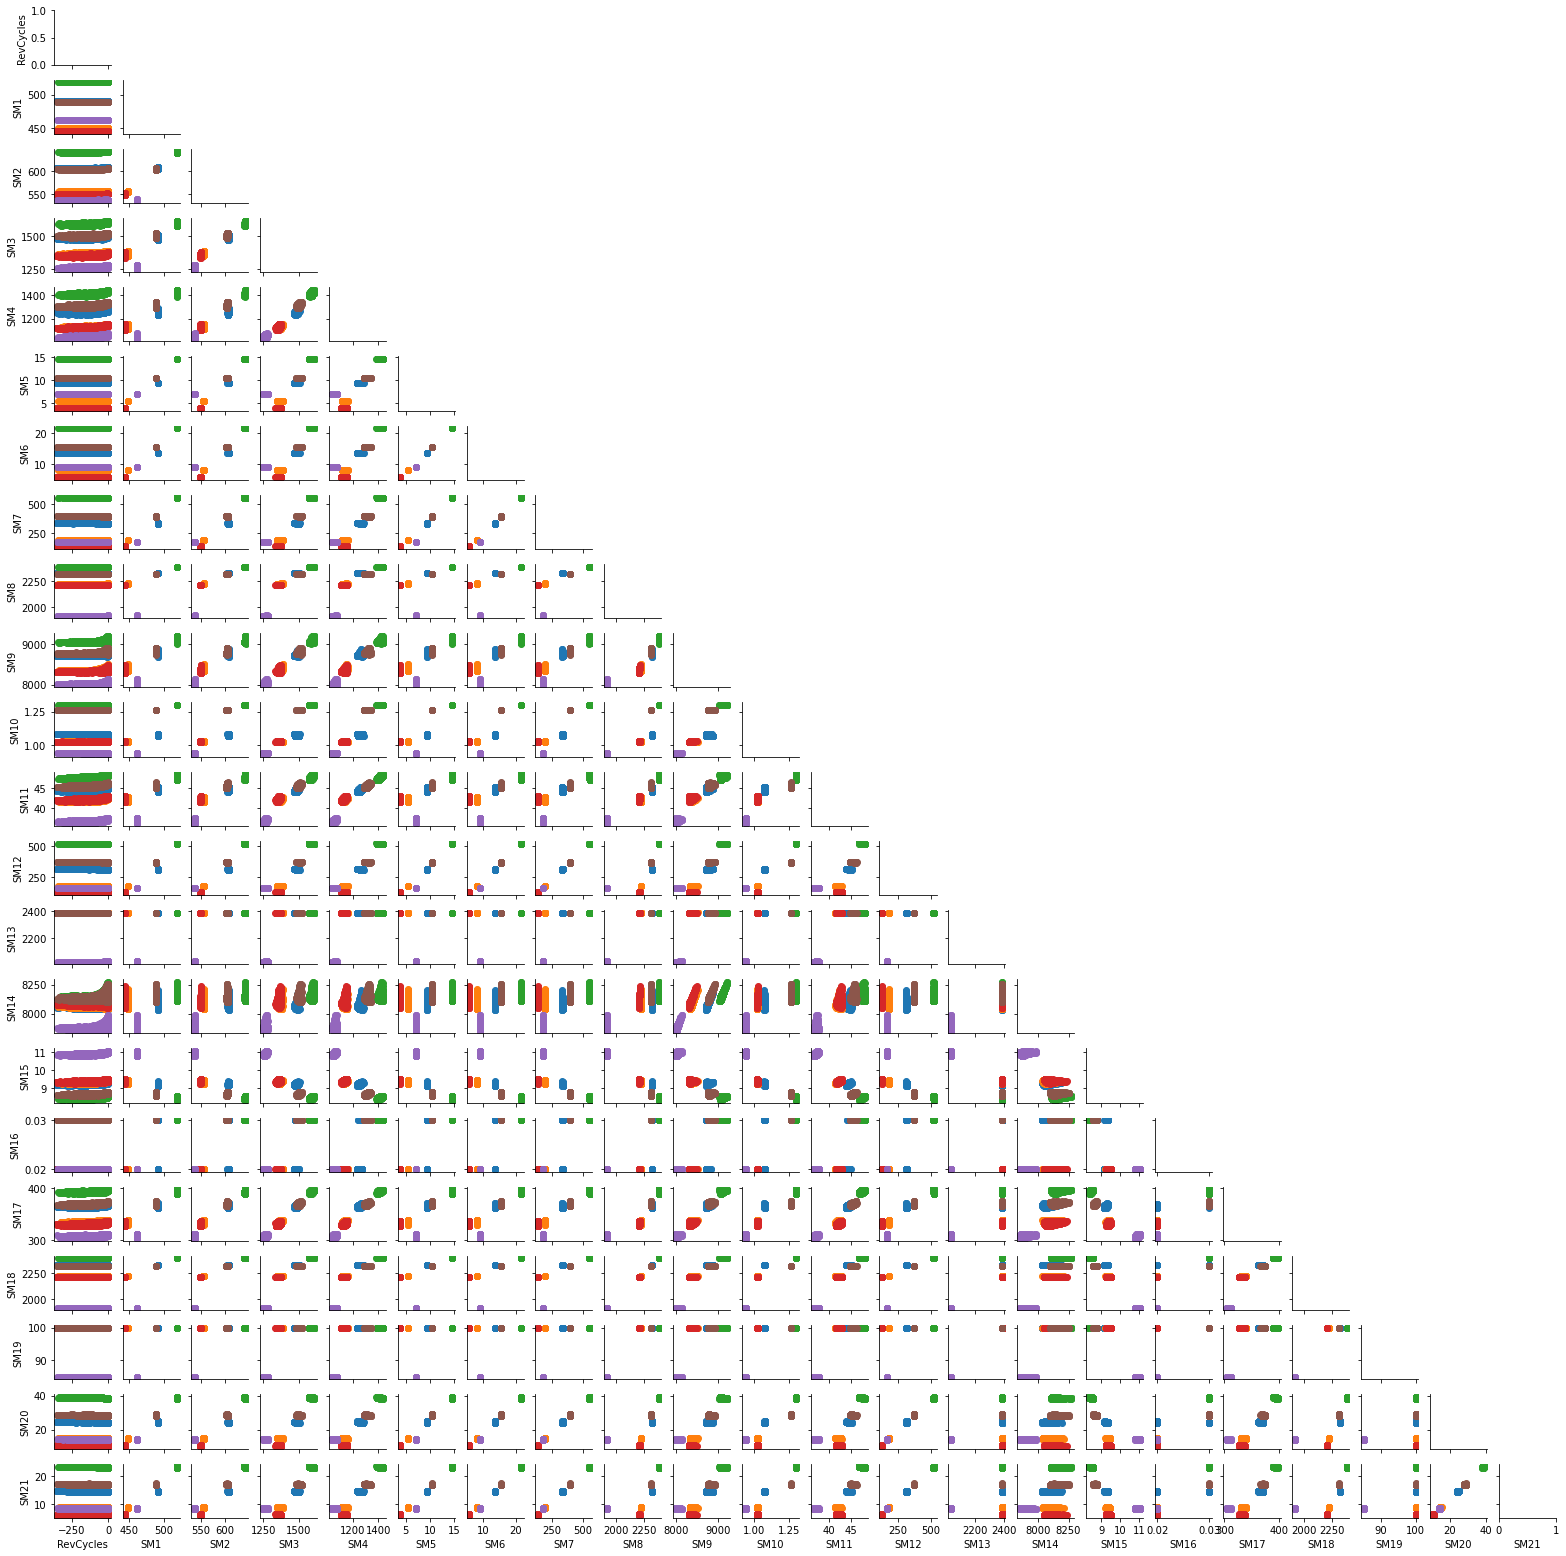

In [10]:
features = ['RevCycles','cluster','SM1','SM2','SM3','SM4','SM5','SM6','SM7','SM8','SM9','SM10','SM11','SM12','SM13','SM14','SM15','SM16','SM17','SM18','SM19','SM20','SM21']
sub_df = df_train[features]

def hide_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
g = sns.PairGrid(sub_df, hue='cluster', vars=[x for x in features if x != 'cluster'], height=1)
g.map_lower(plt.scatter)
g.map_upper(hide_axis)
g.map_diag(hide_axis)
g

With our handy color-coded plot, we can easily see that the clusters we formed in the previous step, we have separated out grouping of units that were subject to similar operating conditions.  So, since the clusters help us to identify those, let's see if we can normalize out the clustering.  This will allow us to develop a more robust model.  

In addition to this cluster, we can see that several of the measurements correlate strongly with each other.  For example, SM21 correlates well with SM6, SM7, SM12, and SM20.  This broadly indicates that principal components can help us in this situation, but first we want to make sure that we have confidence our sensor measurements are continuous variables as opposed to some discrete variable, such as an open or closed vent.  We'll play with this further in a little bit.

In [11]:
red_sensors = ['cluster','SM1','SM2','SM3','SM4','SM5','SM6','SM7','SM8','SM9','SM10','SM11','SM12','SM13','SM14','SM15','SM16','SM17','SM18','SM19','SM20','SM21']

means = df_train[red_sensors].groupby('cluster').mean()
stds = df_train[red_sensors].groupby('cluster').std()

norm_train_df = df_train.copy()


for sensor in [x for x in red_sensors if x != 'cluster']:
    mn = sensor+'_mean'
    sn = sensor+'_std'
    norm_train_df[mn] = norm_train_df['cluster'].apply(lambda x: means[sensor][x])
    norm_train_df[sn] = norm_train_df['cluster'].apply(lambda x: stds[sensor][x])
    norm_train_df[sensor] = (norm_train_df[sensor]-norm_train_df[mn])/norm_train_df[sn]

norm_train_df.head()

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM17_mean,SM17_std,SM18_mean,SM18_std,SM19_mean,SM19_std,SM20_mean,SM20_std,SM21_mean,SM21_std
0,1,1,10.0047,0.2501,20.0,inf,-1.665632,-0.460749,-0.168926,inf,...,369.727260,1.462562,2319.0,0.0,100.0,0.0,28.525501,0.144315,17.115192,0.086270
1,1,2,0.0015,0.0003,100.0,inf,-1.201429,-1.040821,-0.626306,inf,...,393.261576,1.487722,2388.0,0.0,100.0,0.0,38.810095,0.173568,23.285110,0.104452
2,1,3,34.9986,0.8401,60.0,inf,-0.920577,0.218738,-1.283192,-inf,...,334.286631,1.395870,2223.0,0.0,100.0,0.0,14.827492,0.112534,8.896656,0.069070
3,1,4,20.0031,0.7005,0.0,inf,-1.212605,0.422369,-0.577304,inf,...,365.442180,1.434030,2324.0,0.0,100.0,0.0,24.446940,0.133270,14.670230,0.080030
4,1,5,42.0041,0.8405,40.0,NaN,-0.456453,-0.034709,-0.513961,-inf,...,331.119004,1.409473,2212.0,0.0,100.0,0.0,10.583607,0.107765,6.350975,0.063756


After performing the normalization, we can see immediately that several of our sensor measurements "normalized" out, meaning that the values exploded (due to a non-existent standard deviation).  This means there was no predictive value in those sensors anyway, so it's not a huge loss and it simplifies our modelling going forward.  Let's have another look at the normalized data to see what we've got left.

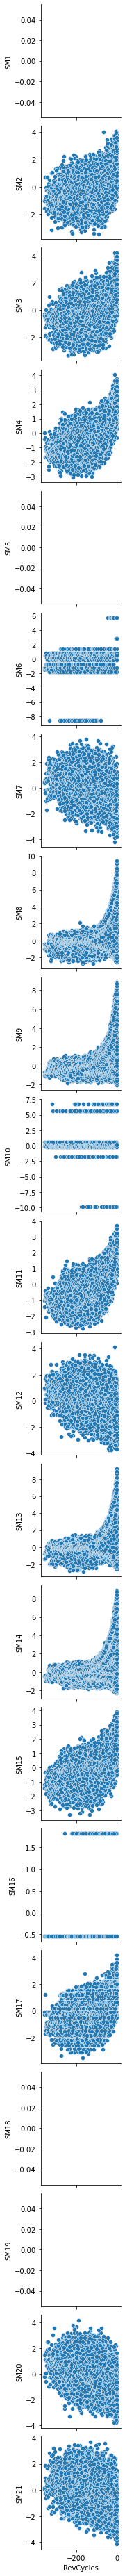

In [12]:
pp = sns.pairplot(
    data=norm_train_df,
    x_vars = 'RevCycles',
    y_vars = [x for x in norm_train_df.columns if ('SM' in x) and ('_mean' not in x) and ('_std' not in x)],
    diag_kind=None
)

With our closer look, it is easy to see that SM1, SM5, SM18, and SM19 have been effectively normalized out as factors, so we can drop those features.  In addition, since we are going to attempt PCA as a step for developing our model, we do not want to maintain categorical or discrete features.  As a result, we will also need to drop SM6, SM10, and SM16, as those are clearly not continuous features.  

In [13]:
cols_to_drop = ['OS1','OS2','OS3','SM1','SM5','SM6','SM10','SM16','SM18','SM19','MaxCycles','Time in Cycles']
cols_to_drop2 = [x for x in norm_train_df.columns if ('_mean' in x) or ('_std' in x)]
red_norm_train_df = norm_train_df.drop(columns=cols_to_drop)
red_norm_train_df = red_norm_train_df.drop(columns=cols_to_drop2)

red_norm_train_df.head()

,Unit Number,SM2,SM3,SM4,SM7,SM8,SM9,SM11,SM12,SM13,SM14,SM15,SM17,SM20,SM21,RevCycles,cluster
0,1,-1.665632,-0.460749,-0.168926,0.854709,-0.979729,-0.778572,-0.381652,1.356057,-0.360213,-0.822667,-1.170261,-1.180982,0.377638,0.675882,-222,5
1,1,-1.201429,-1.040821,-0.626306,0.423932,-1.379841,-0.837832,-1.033286,0.637697,0.652737,-0.472019,-1.468330,-1.520160,1.036511,0.735170,-221,2
2,1,-0.920577,0.218738,-1.283192,1.060663,-0.561667,-0.646282,-0.335412,0.668876,-0.544988,-0.461147,0.550747,-0.205342,0.022284,-0.595856,-220,1
3,1,-1.212605,0.422369,-0.577304,0.608356,-1.335711,-0.431113,-0.877818,-0.016306,-0.651533,-0.817049,-0.314185,-1.005683,-0.202145,1.411592,-219,0
4,1,-0.456453,-0.034709,-0.513961,-0.856394,-0.500056,-0.689555,-1.595426,-0.271838,-0.429268,-0.286493,-2.132310,-0.793917,3.771104,0.808162,-218,3


At this point, let's take one last look over the remaining features for correlations and to see if the normalization we did actually removed the clustering. 

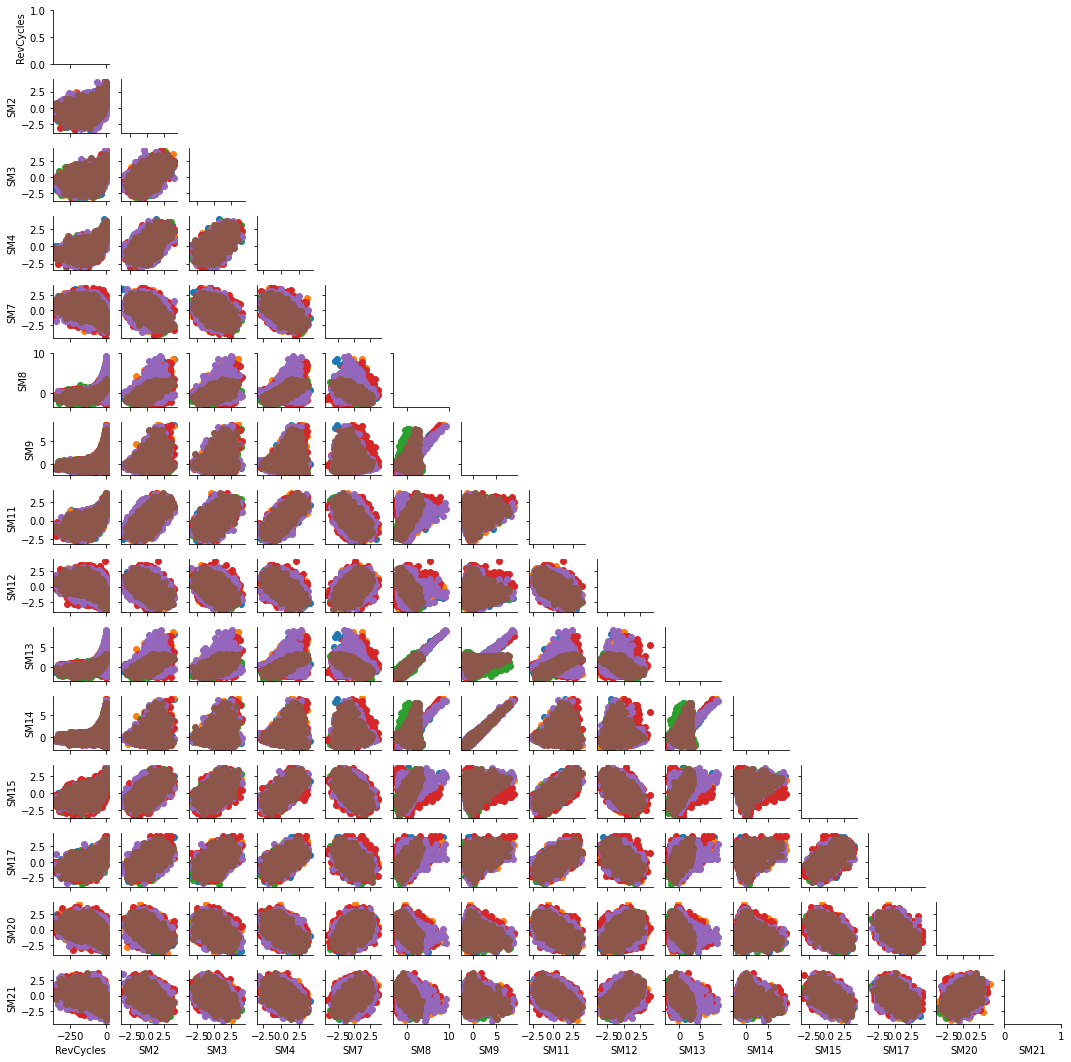

In [14]:
sub_df = red_norm_train_df[['SM2','SM3','SM4','SM7','SM8','SM9','SM11','SM12','SM13','SM14','SM15','SM17','SM20','SM21','cluster','RevCycles']]
def hide_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
g2 = sns.PairGrid(sub_df, hue='cluster', vars=['RevCycles','SM2','SM3','SM4','SM7','SM8','SM9','SM11','SM12','SM13','SM14','SM15','SM17','SM20','SM21'], height=1)
g2.map_lower(plt.scatter)
g2.map_upper(hide_axis)
g2.map_diag(hide_axis)
g2

Now, we can see that this process did remove the operating mode as a separating factor, since all the clusters have collapsed.  We can see in this correlation plot that a few of the modes did show a clear difference based upon operating mode, which hasn't been removed from our data.  However, for the time being, we will move past that and proceed with our modelling.  

Our next step will be to drop features that do not appear to help us, beyond the non-continuous or non-variant ones we already attacked.  In the plot above, we can see that sensors SM8-SM13 and SM9-SM14 correlate well, meaning that they are effectively measuring the same thing.  For this process, we'll drop 8 and 9, since we don't need redundant information, as that will bias our predictor later.

In [15]:
red_norm_train_df = red_norm_train_df.drop(['SM8','SM9'], axis=1)
red_norm_train_df.head()

,Unit Number,SM2,SM3,SM4,SM7,SM11,SM12,SM13,SM14,SM15,SM17,SM20,SM21,RevCycles,cluster
0,1,-1.665632,-0.460749,-0.168926,0.854709,-0.381652,1.356057,-0.360213,-0.822667,-1.170261,-1.180982,0.377638,0.675882,-222,5
1,1,-1.201429,-1.040821,-0.626306,0.423932,-1.033286,0.637697,0.652737,-0.472019,-1.468330,-1.520160,1.036511,0.735170,-221,2
2,1,-0.920577,0.218738,-1.283192,1.060663,-0.335412,0.668876,-0.544988,-0.461147,0.550747,-0.205342,0.022284,-0.595856,-220,1
3,1,-1.212605,0.422369,-0.577304,0.608356,-0.877818,-0.016306,-0.651533,-0.817049,-0.314185,-1.005683,-0.202145,1.411592,-219,0
4,1,-0.456453,-0.034709,-0.513961,-0.856394,-1.595426,-0.271838,-0.429268,-0.286493,-2.132310,-0.793917,3.771104,0.808162,-218,3


There are many approaches that we could take at this point, but our goal is to make a linear or polynomial model, so we'd like to reduce the sensor data down to a "health index" or something of the sort that will enable us to make predictions. We can do this via a polynomial fit to the combination of sensors that we have retained, if we assume that (within the training data) the health index starts a 1 (full health) and ends at 0 (no health).  We have to do some mathematical gymnatstics to make this work.

In [16]:
ntrain_df = red_norm_train_df.copy()

cycles = {}

for i in ntrain_df['Unit Number'].unique():
    cycles[i] = min(ntrain_df[ntrain_df['Unit Number']==i]['RevCycles'])
    
ntrain_df['MC'] = ntrain_df['Unit Number'].apply(lambda x: cycles[x])
ntrain_df['Marker'] = ntrain_df['MC'].apply(lambda x: int(abs(x))) - ntrain_df['RevCycles'].apply(lambda x: int(abs(x))) - 10
ntrain_df['Marker2'] = ntrain_df['Marker'] + ntrain_df['MC'] +20
ntrain_df['H1'] = np.nan
ntrain_df['H1'] = ntrain_df['Marker'].apply(lambda x: 1.5 if x <= 0 else 1.0)
ntrain_df['H2'] = np.nan
ntrain_df['H2'] = ntrain_df['Marker2'].apply(lambda x: 0.5 if x >= 0 else 1.0)
ntrain_df['Health'] = ntrain_df['H1'] + ntrain_df['H2'] - 1.5
ntrain_df['Health'] = ntrain_df['Health'].apply(lambda x: np.nan if x==0.5 else x)
ntrain_df.head(20)

,Unit Number,SM2,SM3,SM4,SM7,SM11,SM12,SM13,SM14,SM15,...,SM20,SM21,RevCycles,cluster,MC,Marker,Marker2,H1,H2,Health
0,1,-1.665632,-0.460749,-0.168926,0.854709,-0.381652,1.356057,-0.360213,-0.822667,-1.170261,...,0.377638,0.675882,-222,5,-222,-10,-212,1.5,1.0,1.0
1,1,-1.201429,-1.040821,-0.626306,0.423932,-1.033286,0.637697,0.652737,-0.472019,-1.468330,...,1.036511,0.735170,-221,2,-222,-9,-211,1.5,1.0,1.0
2,1,-0.920577,0.218738,-1.283192,1.060663,-0.335412,0.668876,-0.544988,-0.461147,0.550747,...,0.022284,-0.595856,-220,1,-222,-8,-210,1.5,1.0,1.0
3,1,-1.212605,0.422369,-0.577304,0.608356,-0.877818,-0.016306,-0.651533,-0.817049,-0.314185,...,-0.202145,1.411592,-219,0,-222,-7,-209,1.5,1.0,1.0
4,1,-0.456453,-0.034709,-0.513961,-0.856394,-1.595426,-0.271838,-0.429268,-0.286493,-2.132310,...,3.771104,0.808162,-218,3,-222,-6,-208,1.5,1.0,1.0
5,1,-0.486520,-0.966456,0.668783,0.091537,-0.283821,1.047487,-0.803946,-0.761349,-0.195917,...,-0.052074,0.395726,-217,0,-222,-5,-207,1.5,1.0,1.0
6,1,-0.342574,-0.043535,0.428604,1.108920,-0.315426,-1.088904,-0.459980,-0.386247,-0.052386,...,-0.497447,1.167346,-216,3,-222,-4,-206,1.5,1.0,1.0
7,1,-1.304856,-0.192467,-0.210731,0.201810,-0.215623,0.539062,-1.091965,-0.447119,-0.279655,...,0.978897,-0.492184,-215,2,-222,-3,-205,1.5,1.0,1.0
8,1,-0.022372,-0.764258,-1.193000,0.692816,-0.994350,0.510881,-0.365006,-0.480912,-1.427056,...,1.036511,-0.420381,-214,2,-222,-2,-204,1.5,1.0,1.0
9,1,0.249594,-0.262440,-0.412026,-0.562727,-1.083426,-0.622009,-0.367845,-0.150083,-0.285597,...,1.544034,1.189305,-213,3,-222,-1,-203,1.5,1.0,1.0


Let's check, for a random engine, to ensure that our mathematical double bar exercise did the trick.  For engine #4, we get:

In [17]:
ntrain_df[ntrain_df['Unit Number']==4].head(20)

,Unit Number,SM2,SM3,SM4,SM7,SM11,SM12,SM13,SM14,SM15,...,SM20,SM21,RevCycles,cluster,MC,Marker,Marker2,H1,H2,Health
537,4,-1.284771,-0.336519,-0.634036,0.534392,-0.509571,0.431125,-0.544988,-0.302576,-0.860371,...,0.733183,-0.301953,-158,1,-158,-10,-148,1.5,1.0,1.0
538,4,-1.221509,0.148321,-0.208688,1.038841,-1.302848,0.326575,-0.990009,-0.560673,-1.229190,...,1.070567,0.882212,-157,5,-158,-9,-147,1.5,1.0,1.0
539,4,-0.375560,-0.646567,-1.118384,0.716609,-0.581912,1.203541,-1.304907,-0.567702,-0.974726,...,0.031173,-0.485591,-156,5,-158,-8,-146,1.5,1.0,1.0
540,4,0.149243,-0.363044,-0.131244,-0.265540,-1.336825,1.540627,-0.512014,-0.436109,-0.765947,...,-1.932690,-0.016736,-155,1,-158,-7,-145,1.5,1.0,1.0
541,4,-1.010022,-1.697815,-1.275020,0.931431,-0.501808,0.955703,-0.780077,-0.846949,-1.314904,...,1.070567,1.490768,-154,5,-158,-6,-144,1.5,1.0,1.0
542,4,-1.676381,-0.646715,-0.893297,1.998308,-0.926763,-0.092144,-0.461319,-0.544193,-1.082615,...,0.788272,-0.185090,-153,4,-158,-5,-143,1.5,1.0,1.0
543,4,-0.925427,-0.108039,-1.284660,0.593854,-1.222744,1.470444,-0.780077,-0.283981,-1.057762,...,1.070567,0.259745,-152,5,-158,-4,-142,1.5,1.0,1.0
544,4,1.640875,-1.187996,-0.995699,0.145151,-0.506971,1.255322,-0.569443,-0.364453,-0.936722,...,1.774374,-0.352102,-151,4,-158,-3,-141,1.5,1.0,1.0
545,4,-1.967636,-1.017327,-1.059579,-0.223438,-1.206206,0.959459,-0.446067,-0.307712,-0.834142,...,0.733183,0.967768,-150,1,-158,-2,-140,1.5,1.0,1.0
546,4,-1.477912,-0.391322,-0.948104,1.462455,-1.253268,-0.238607,-0.425278,-0.770588,-1.267261,...,-0.377121,-1.058922,-149,4,-158,-1,-139,1.5,1.0,1.0


In [18]:
ntrain_df[ntrain_df['Unit Number']==4].tail(20)

,Unit Number,SM2,SM3,SM4,SM7,SM11,SM12,SM13,SM14,SM15,...,SM20,SM21,RevCycles,cluster,MC,Marker,Marker2,H1,H2,Health
676,4,0.851065,0.655879,1.123927,-1.262818,1.861259,-0.988874,1.004346,0.873907,1.446696,...,-1.077515,-1.293523,-19,5,-158,129,-9,1.0,1.0,NaN
677,4,1.433930,0.960953,2.238277,-0.607906,1.903241,0.340961,0.768488,0.644945,0.891309,...,-0.961419,-1.207346,-18,3,-158,130,-8,1.0,1.0,NaN
678,4,0.081481,1.890062,0.817251,-1.574043,1.172196,-1.263853,0.764085,0.674978,2.017610,...,-0.018539,1.865285,-17,4,-158,131,-7,1.0,1.0,NaN
679,4,0.773451,-0.188505,1.573863,-1.508933,0.946602,-0.098136,1.101221,1.072888,1.110280,...,-1.402712,-1.073719,-16,0,-158,132,-6,1.0,1.0,NaN
680,4,2.087521,1.519513,0.283838,-0.499627,1.108214,-1.954985,0.943520,0.789575,0.719161,...,-1.440906,-0.494099,-15,2,-158,133,-5,1.0,1.0,NaN
681,4,1.320052,0.978606,1.197748,-3.296095,1.519241,-1.263989,0.891335,0.726070,0.736738,...,-1.054214,-0.978346,-14,3,-158,134,-4,1.0,1.0,NaN
682,4,1.971947,0.167247,1.995066,-1.984004,1.981415,-0.359746,1.424211,0.808728,1.588660,...,-1.354687,-1.404802,-13,5,-158,135,-3,1.0,1.0,NaN
683,4,1.782638,1.148660,1.682620,0.658676,2.105066,-0.385071,0.800127,1.307508,1.926427,...,-1.273578,-1.096202,-12,4,-158,136,-2,1.0,1.0,NaN
684,4,1.612419,0.334139,2.130015,-1.707805,2.462039,-2.247129,1.004346,0.920555,1.510981,...,-0.800343,-0.678011,-11,5,-158,137,-1,1.0,1.0,NaN
685,4,0.376865,1.426509,1.126413,-0.581303,1.754492,-1.180295,1.103701,0.919122,1.230077,...,-1.221790,-0.834743,-10,1,-158,138,0,1.0,0.5,0.0


Great! That did it.  So, now we can drop all of the excess columns that we don't need anymore. 

In [19]:
red_train_df = ntrain_df.copy().drop(['Unit Number','cluster','RevCycles','MC','Marker','Marker2','H1','H2'], axis=1).dropna()
red_train_df.head()

,SM2,SM3,SM4,SM7,SM11,SM12,SM13,SM14,SM15,SM17,SM20,SM21,Health
0,-1.665632,-0.460749,-0.168926,0.854709,-0.381652,1.356057,-0.360213,-0.822667,-1.170261,-1.180982,0.377638,0.675882,1.0
1,-1.201429,-1.040821,-0.626306,0.423932,-1.033286,0.637697,0.652737,-0.472019,-1.468330,-1.520160,1.036511,0.735170,1.0
2,-0.920577,0.218738,-1.283192,1.060663,-0.335412,0.668876,-0.544988,-0.461147,0.550747,-0.205342,0.022284,-0.595856,1.0
3,-1.212605,0.422369,-0.577304,0.608356,-0.877818,-0.016306,-0.651533,-0.817049,-0.314185,-1.005683,-0.202145,1.411592,1.0
4,-0.456453,-0.034709,-0.513961,-0.856394,-1.595426,-0.271838,-0.429268,-0.286493,-2.132310,-0.793917,3.771104,0.808162,1.0


Just to verify that this worked, let's check the correlation between the various sensors and the health index we've made.  Ideally, this should show a strong correlation (either positive or negative and close to 1) between each of the sensors and the 'Health' column.

In [20]:
df_corr_ = red_train_df.corr()
df_corr_[['Health']]

,Health
SM2,-0.826437
SM3,-0.816026
SM4,-0.898198
SM7,0.702196
SM11,-0.924286
SM12,0.719411
SM13,-0.519472
SM14,-0.365408
SM15,-0.888004
SM17,-0.838119


With this table, we can see that most of the sensors show a strong correlation.  The few standouts here are SM13 and SM14.  We could also argue that SM20 and SM21 are not strongly correlated.  For now, we'll continue as if they are correlated. At this point, we are ready to do a linear regression model for each of these sensors against the health index.

In [21]:
fit_m = ols('Health ~ SM2+SM3+SM4+SM7+SM11+SM12+SM13+SM14+SM15+SM17+SM20+SM21',red_train_df).fit()
print(fit_m.summary())

                            OLS Regression Results                            
Dep. Variable:                 Health   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     4242.
Date:                Tue, 18 May 2021   Prob (F-statistic):               0.00
Time:                        12:17:38   Log-Likelihood:                 2405.2
No. Observations:                4796   AIC:                            -4784.
Df Residuals:                    4783   BIC:                            -4700.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7164      0.002    307.786      0.0

Based upon the P value listed for these fits, we can see that SM13 and SM21 appear to be the least correlated, but are still significant (P < 0.5).  So, now we need to revisit our test data and follow the same process of (1) normalizing out the operating modes and (2) dropping sensors that we chose not to use.  

In [22]:
df_test

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM14,SM15,SM16,SM17,SM18,SM19,SM20,SM21,MaxCycles,RevCycles
0,1,1,0.0016,0.0002,100.0,518.67,642.88,1587.21,1412.44,14.62,...,8124.04,8.4363,0.03,393,2388,100.00,38.97,23.3029,223,-222
1,1,2,24.9993,0.6215,80.0,462.54,536.45,1262.64,1055.44,7.05,...,7865.20,10.8935,0.02,308,1915,84.93,14.29,8.6686,223,-221
2,1,3,0.0004,0.0000,100.0,518.67,642.65,1589.75,1409.54,14.62,...,8121.12,8.4620,0.03,393,2388,100.00,38.91,23.2693,223,-220
3,1,4,10.0034,0.2500,20.0,489.05,604.44,1499.93,1315.34,10.52,...,8123.53,8.6815,0.03,369,2319,100.00,28.60,17.0930,223,-219
4,1,5,0.0024,0.0011,100.0,518.67,642.74,1585.47,1408.12,14.62,...,8118.30,8.4617,0.03,392,2388,100.00,38.82,23.3124,223,-218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29815,218,86,35.0013,0.8404,60.0,449.44,556.14,1367.80,1129.58,5.48,...,8065.66,9.3426,0.02,335,2223,100.00,14.62,8.8457,149,-63
29816,218,87,25.0041,0.6200,80.0,462.54,536.97,1262.93,1051.83,7.05,...,7871.94,10.9421,0.02,306,1915,84.93,14.41,8.4964,149,-62
29817,218,88,20.0043,0.7000,0.0,491.19,607.93,1492.15,1252.99,9.35,...,8059.65,9.2862,0.02,368,2324,100.00,24.42,14.5244,149,-61
29818,218,89,20.0037,0.7000,0.0,491.19,607.85,1490.80,1254.70,9.35,...,8062.13,9.2599,0.02,365,2324,100.00,24.45,14.5694,149,-60


First, we'll use our cluster predictor from earlier to determine our clusters in the same manner.  Then, we'll normalize them out, so the operating mode becomes irrelevant to further analysis.

In [23]:
X = df_test[['OS1','OS2','OS3']]

y_km = km.predict(X)

df_test['cluster'] = y_km

df_test.head()

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM15,SM16,SM17,SM18,SM19,SM20,SM21,MaxCycles,RevCycles,cluster
0,1,1,0.0016,0.0002,100.0,518.67,642.88,1587.21,1412.44,14.62,...,8.4363,0.03,393,2388,100.00,38.97,23.3029,223,-222,2
1,1,2,24.9993,0.6215,80.0,462.54,536.45,1262.64,1055.44,7.05,...,10.8935,0.02,308,1915,84.93,14.29,8.6686,223,-221,4
2,1,3,0.0004,0.0000,100.0,518.67,642.65,1589.75,1409.54,14.62,...,8.4620,0.03,393,2388,100.00,38.91,23.2693,223,-220,2
3,1,4,10.0034,0.2500,20.0,489.05,604.44,1499.93,1315.34,10.52,...,8.6815,0.03,369,2319,100.00,28.60,17.0930,223,-219,5
4,1,5,0.0024,0.0011,100.0,518.67,642.74,1585.47,1408.12,14.62,...,8.4617,0.03,392,2388,100.00,38.82,23.3124,223,-218,2


In [24]:
red_sensors = ['cluster','SM2','SM3','SM4','SM7','SM11','SM12','SM13','SM14','SM15','SM17','SM20','SM21']

means = df_test[red_sensors].groupby('cluster').mean()
stds = df_test[red_sensors].groupby('cluster').std()

norm_test_df = df_test.copy()


for sensor in [x for x in red_sensors if x != 'cluster']:
    mn = sensor+'_mean'
    sn = sensor+'_std'
    norm_test_df[mn] = norm_test_df['cluster'].apply(lambda x: means[sensor][x])
    norm_test_df[sn] = norm_test_df['cluster'].apply(lambda x: stds[sensor][x])
    norm_test_df[sensor] = (norm_test_df[sensor]-norm_test_df[mn])/norm_test_df[sn]

norm_test_df.head()

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM14_mean,SM14_std,SM15_mean,SM15_std,SM17_mean,SM17_std,SM20_mean,SM20_std,SM21_mean,SM21_std
0,1,1,0.0016,0.0002,100.0,518.67,0.892997,-0.261926,1.032688,14.62,...,8138.818139,11.243124,8.428458,0.029050,392.648630,1.228919,38.879057,0.140836,23.329463,0.086889
1,1,2,24.9993,0.6215,80.0,462.54,-1.044447,0.364410,1.389960,7.05,...,7875.795479,8.808358,10.895641,0.031921,306.926076,1.104723,14.285427,0.105162,8.572140,0.062305
2,1,3,0.0004,0.0000,100.0,518.67,0.314783,0.247527,0.602306,14.62,...,8138.818139,11.243124,8.428458,0.029050,392.648630,1.228919,38.879057,0.140836,23.329463,0.086889
3,1,4,10.0034,0.2500,20.0,489.05,-0.743742,-0.035385,1.151085,10.52,...,8132.443243,11.266369,8.649858,0.029377,369.195193,1.209876,28.577089,0.124692,17.145019,0.075167
4,1,5,0.0024,0.0011,100.0,518.67,0.541041,-0.610922,0.391568,14.62,...,8138.818139,11.243124,8.428458,0.029050,392.648630,1.228919,38.879057,0.140836,23.329463,0.086889


Now, we extract just the sensors of interest and predict our Health index.

In [25]:
df_test_red = norm_test_df.drop(['cluster','Unit Number','Time in Cycles','OS1','OS2','OS3','SM1','SM5','SM6','SM8','SM9','SM10','SM16','SM18','SM19','MaxCycles','RevCycles'], axis=1)
cols_to_drop2 = [x for x in df_test_red if ('_std' in x) or ('_mean') in x]
df_test_red = df_test_red.drop(cols_to_drop2, axis=1)
df_test_red.head()

,SM2,SM3,SM4,SM7,SM11,SM12,SM13,SM14,SM15,SM17,SM20,SM21
0,0.892997,-0.261926,1.032688,-0.527303,0.657835,-0.436072,0.405768,-1.314416,0.269937,0.285918,0.645736,-0.305712
1,-1.044447,0.364410,1.389960,-1.102306,0.549642,-0.981839,-1.709345,-1.202889,-0.067083,0.972120,0.043485,1.548184
2,0.314783,0.247527,0.602306,0.893031,0.254289,-0.953378,1.965571,-1.574130,1.154604,0.285918,0.219709,-0.692414
3,-0.743742,-0.035385,1.151085,-1.291081,0.135661,-0.521275,1.228810,-0.791137,1.077101,-0.161333,0.183741,-0.692046
4,0.541041,-0.610922,0.391568,-0.237439,1.111824,-1.470683,0.925702,-1.824950,1.144277,-0.527806,-0.419331,-0.196377


In [26]:
df_test['Health'] = fit_m.predict(df_test_red)
df_test.head()

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM16,SM17,SM18,SM19,SM20,SM21,MaxCycles,RevCycles,cluster,Health
0,1,1,0.0016,0.0002,100.0,518.67,642.88,1587.21,1412.44,14.62,...,0.03,393,2388,100.00,38.97,23.3029,223,-222,2,0.569572
1,1,2,24.9993,0.6215,80.0,462.54,536.45,1262.64,1055.44,7.05,...,0.02,308,1915,84.93,14.29,8.6686,223,-221,4,0.582041
2,1,3,0.0004,0.0000,100.0,518.67,642.65,1589.75,1409.54,14.62,...,0.03,393,2388,100.00,38.91,23.2693,223,-220,2,0.611361
3,1,4,10.0034,0.2500,20.0,489.05,604.44,1499.93,1315.34,10.52,...,0.03,369,2319,100.00,28.60,17.0930,223,-219,5,0.591590
4,1,5,0.0024,0.0011,100.0,518.67,642.74,1585.47,1408.12,14.62,...,0.03,392,2388,100.00,38.82,23.3124,223,-218,2,0.549298


With our shiny new Health Index, we can take a look and see what that index looks like against our operating cycles. 

<AxesSubplot:xlabel='Time in Cycles'>

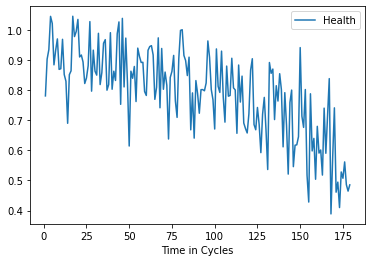

In [27]:
sub_df = df_test[df_test['Unit Number']==50]
sub_df.plot(x='Time in Cycles',y='Health')

We do have a clear trend in our health index.  However, it is **very** noisy.  We could just continue with the health index as is, but in order to give a more precise predition, we will average out the noise.  To do this, we'll use the rolling function chained with the mean function.  Following this, we'll use itertools to merge the data in.  We alos have to drop empty rows, given that the rolling average will reduce the overall data we have available.

In [28]:
def move_avg(df,un):
    tdf = df[df['Unit Number']==un]
    rolling=tdf['Health'].rolling(10).mean()
    return rolling

In [29]:
rolling_means = [move_avg(df_test,i) for i in df_test['Unit Number'].unique()]
df_test = df_test.assign(Health1=list(itertools.chain.from_iterable(rolling_means)))
df_test.dropna(inplace=True)
df_test.head()

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM17,SM18,SM19,SM20,SM21,MaxCycles,RevCycles,cluster,Health,Health1
9,1,10,25.0039,0.6200,80.0,462.54,536.93,1263.95,1048.91,7.05,...,306,1915,84.93,14.33,8.5092,223,-213,4,0.672164,0.603864
10,1,11,20.0011,0.7000,0.0,491.19,607.69,1480.73,1249.17,9.35,...,365,2324,100.00,24.28,14.6427,223,-212,0,0.580028,0.604909
11,1,12,0.0016,0.0009,100.0,518.67,642.10,1593.31,1409.46,14.62,...,393,2388,100.00,38.89,23.3587,223,-211,2,0.519111,0.598616
12,1,13,42.0029,0.8400,40.0,445.00,549.53,1360.67,1122.25,3.91,...,332,2212,100.00,10.63,6.3758,223,-210,3,0.527539,0.590234
13,1,14,35.0034,0.8400,60.0,449.44,555.98,1358.08,1132.48,5.48,...,334,2223,100.00,14.90,8.9530,223,-209,1,0.540528,0.585128


Now we can check the health index to see if it looks smoother than the chart above.

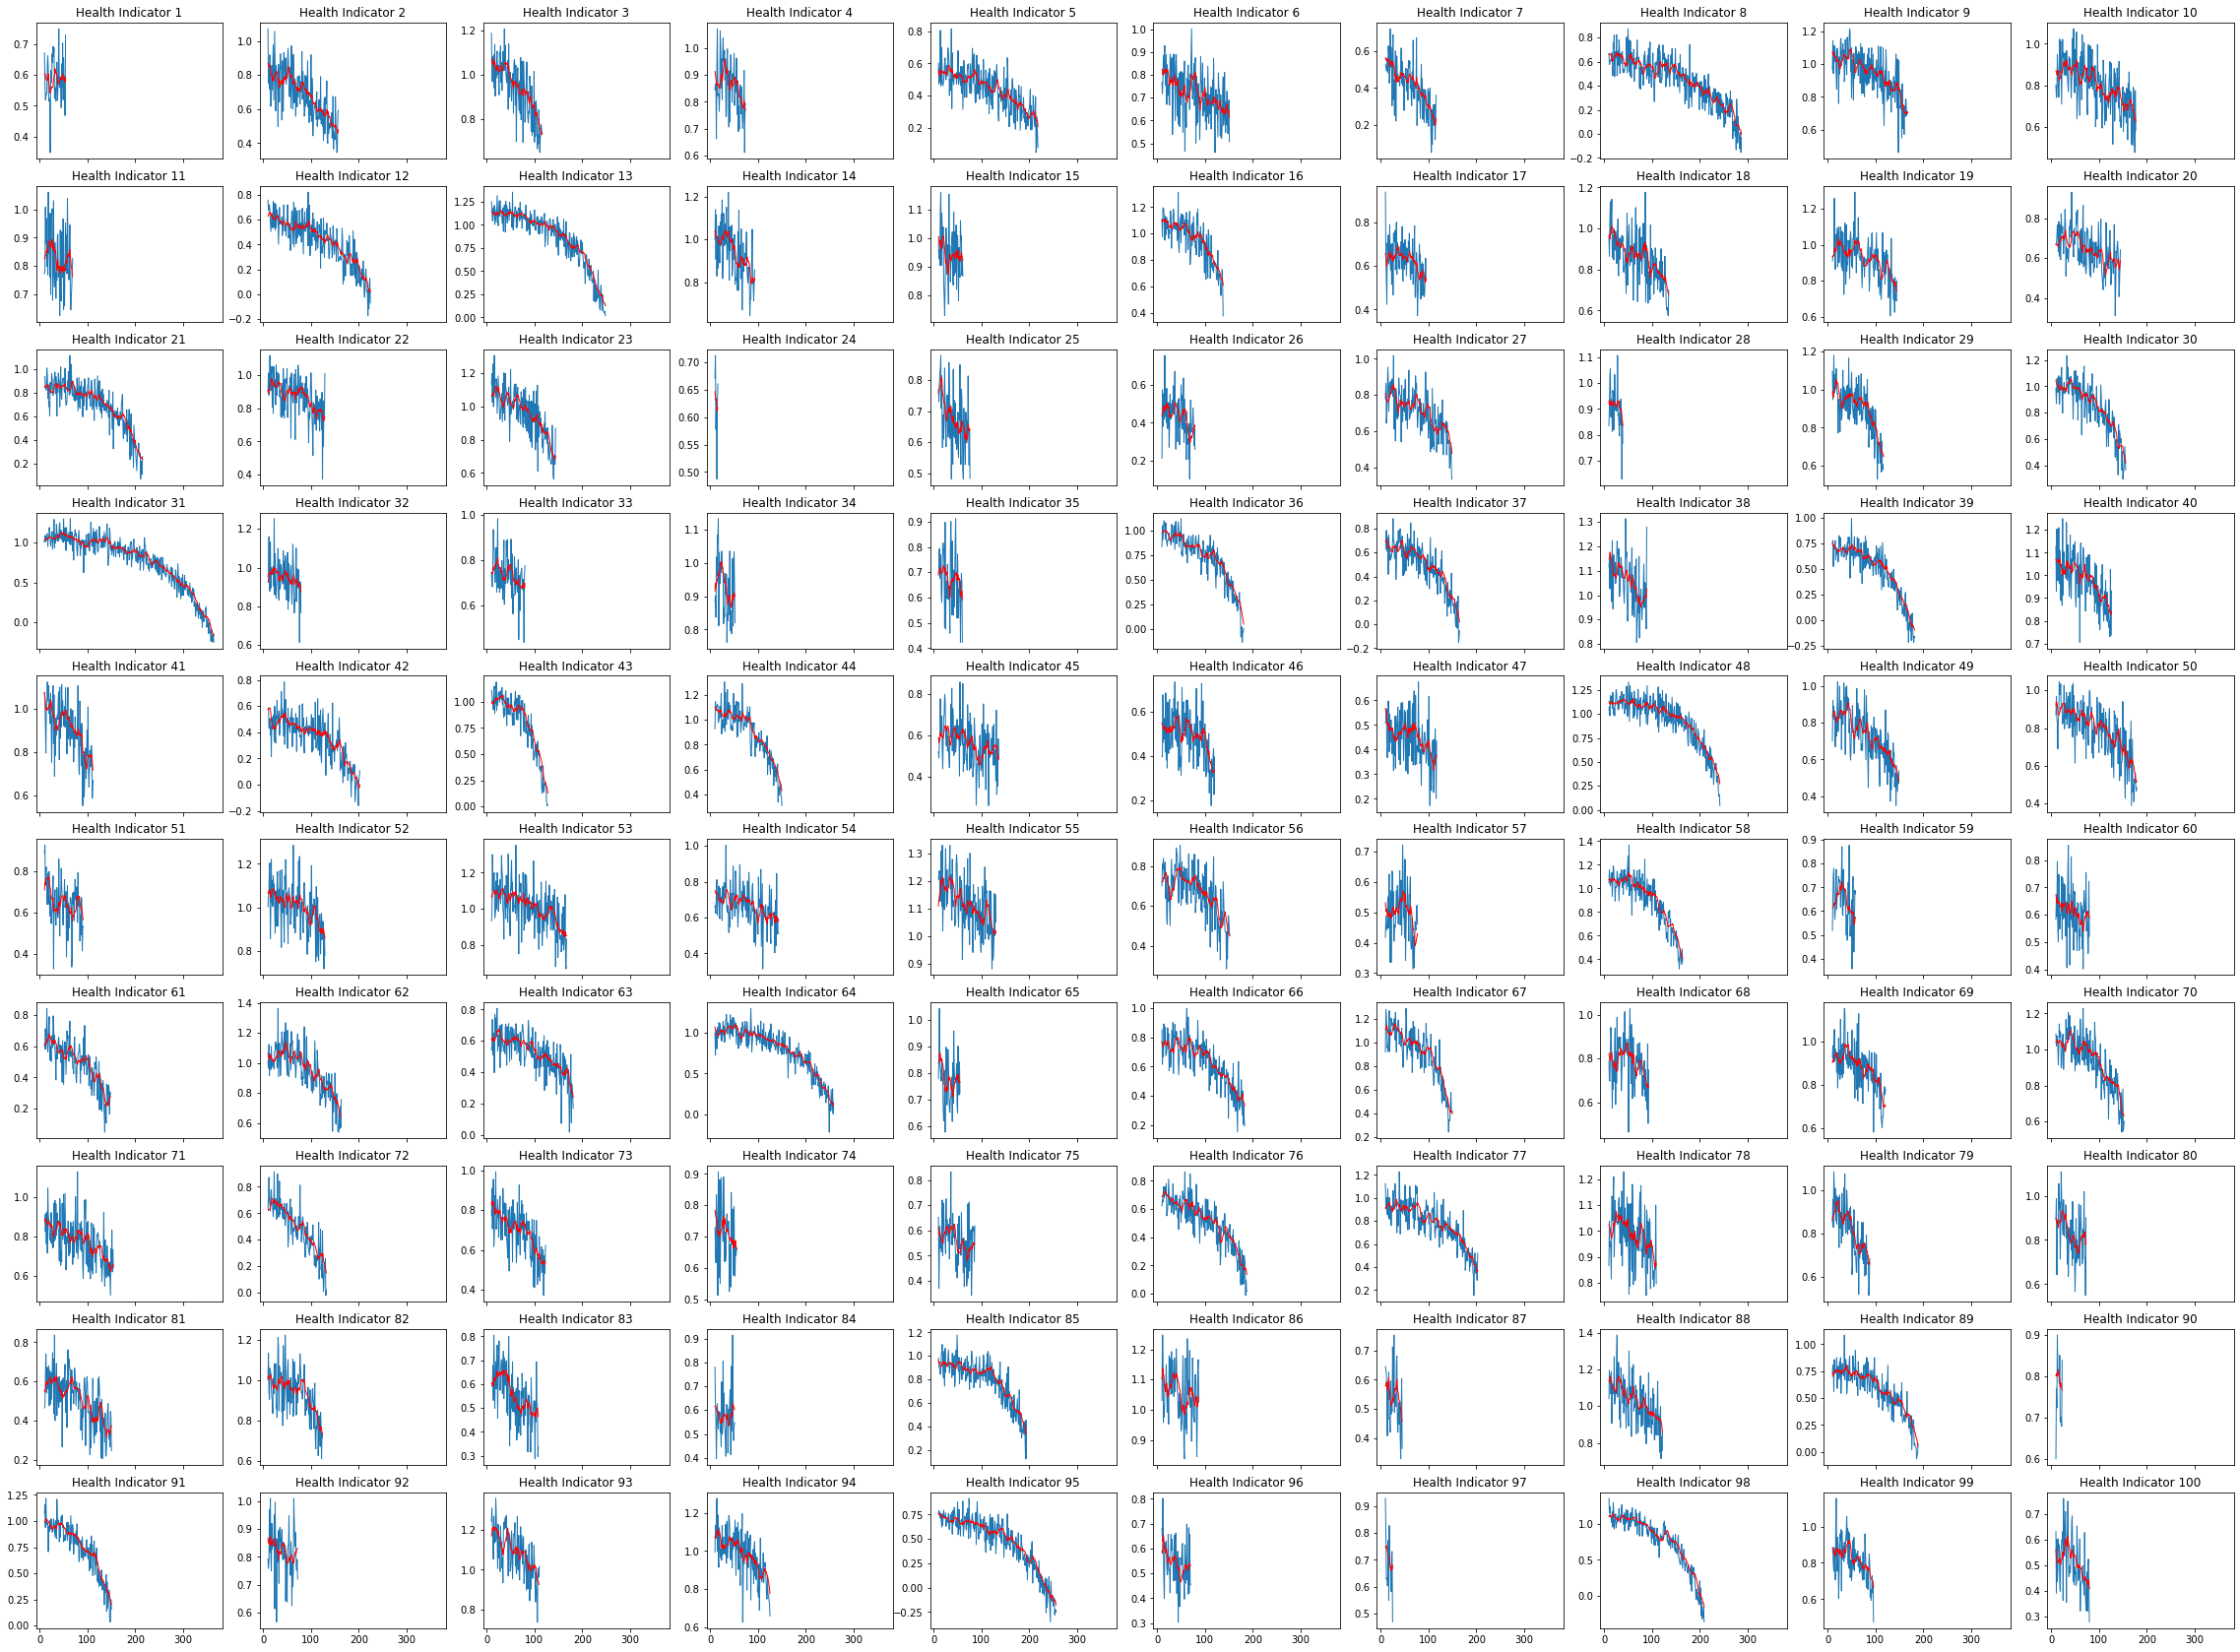

In [30]:
fig,ax=plt.subplots(10,10,figsize=(40,30),sharex=True)
c=1
for i in range(0,10):
    for j in range(0,10):
        df_un = df_test[df_test['Unit Number']==c]
        ax[i,j].plot(df_un['Time in Cycles'],df_un['Health'],linewidth=1)
        ax[i,j].plot(df_un['Time in Cycles'],df_un['Health1'],linewidth=1,color='r')
        ax[i,j].set_title('Health Indicator '+str(c))
        c+=1

From this, we can see that the smoothed health index does appear to be a cleaner approach and will lead to better extrapolations down the road.  One other thing to note here is that several of the engines only have a few cycles of test data available for us to fit.  These will most certainly be poor fits later, primarily because our approach requires more data than in avaialble.  

Now we'll move into the prediction phase, for which we'll need to obtain the actual cycles that each of the above engines ran for.  For ease of use in a bit, let's define our scoring function, in accordance with the competition guidance.

In [31]:
def scoring_function(error):
    if error >= 0:
        s = np.exp(error/10)-1
        return s
    else:
        s = np.exp(-error/13)-1
        return s

Before moving on, we need to import the actual test data, relabel our columns and assemble the actual remaining usable life for each engine, since this is what we'll be predicting against later.

In [32]:
df_test_results = pd.read_csv('final_test.txt', header=None, delimiter=r"\s+")
df_test_results.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,10.0047,0.2501,20.0,489.05,605.02,1498.72,1304.90,10.52,...,371.83,2388.12,8128.58,8.6402,0.03,371,2319,100.0,28.52,17.0653
1,1,2,0.0015,0.0003,100.0,518.67,642.69,1592.90,1405.35,14.62,...,521.88,2388.09,8128.07,8.4286,0.03,392,2388,100.0,38.95,23.3609
2,1,3,34.9986,0.8401,60.0,449.44,555.49,1357.71,1127.52,5.48,...,182.97,2387.92,8060.07,9.3065,0.02,333,2223,100.0,14.91,8.8185
3,1,4,20.0031,0.7005,0.0,491.19,607.62,1479.86,1257.25,9.35,...,315.29,2388.09,8060.00,9.2381,0.02,365,2324,100.0,24.35,14.7075
4,1,5,42.0041,0.8405,40.0,445.00,549.69,1354.17,1124.17,3.91,...,130.50,2387.84,8080.66,9.3950,0.02,331,2212,100.0,10.67,6.4837


In [33]:
df_test_results.columns = [
    'Unit Number',
    'Time in Cycles',
    'OS1',
    'OS2',
    'OS3',
    'SM1',
    'SM2',
    'SM3',
    'SM4',
    'SM5',
    'SM6',
    'SM7',
    'SM8',
    'SM9',
    'SM10',
    'SM11',
    'SM12',
    'SM13',
    'SM14',
    'SM15',
    'SM16',
    'SM17',
    'SM18',
    'SM19',
    'SM20',
    'SM21'
]

df_test_results.head()

,Unit Number,Time in Cycles,OS1,OS2,OS3,SM1,SM2,SM3,SM4,SM5,...,SM12,SM13,SM14,SM15,SM16,SM17,SM18,SM19,SM20,SM21
0,1,1,10.0047,0.2501,20.0,489.05,605.02,1498.72,1304.90,10.52,...,371.83,2388.12,8128.58,8.6402,0.03,371,2319,100.0,28.52,17.0653
1,1,2,0.0015,0.0003,100.0,518.67,642.69,1592.90,1405.35,14.62,...,521.88,2388.09,8128.07,8.4286,0.03,392,2388,100.0,38.95,23.3609
2,1,3,34.9986,0.8401,60.0,449.44,555.49,1357.71,1127.52,5.48,...,182.97,2387.92,8060.07,9.3065,0.02,333,2223,100.0,14.91,8.8185
3,1,4,20.0031,0.7005,0.0,491.19,607.62,1479.86,1257.25,9.35,...,315.29,2388.09,8060.00,9.2381,0.02,365,2324,100.0,24.35,14.7075
4,1,5,42.0041,0.8405,40.0,445.00,549.69,1354.17,1124.17,3.91,...,130.50,2387.84,8080.66,9.3950,0.02,331,2212,100.0,10.67,6.4837


With our imported actual lifespans for the test engines, we'll extract the maximum number of cycles that each engine ran for.  This will be the number we compare our predictions against, to score this approach. We'll also check that the number of entries we get equates to the number of untis we are expecting.

In [34]:
RUL_list = [df_test_results[df_test_results['Unit Number']==x]['Time in Cycles'].max() for x in df_test_results['Unit Number'].unique()]
print(len(RUL_list), len(list(df_test_results['Unit Number'].unique())))

435 435


Now that we've got our actual test data loaded, let's make predictions on the partial test data and see what we get.  After that, we'll rework some of the data to make our job easier later on.

In [35]:
degrees    = range(6)
degree_fit = []
final_score=[]
estimated_rul_dict={}
roots_dict={}

for i in df_test['Unit Number'].unique():
    
    uniti = df_test[df_test['Unit Number']==i]
    
    score = np.empty(len(degrees))
    
    estimated_rul_dict[i] = {}
    roots_dict[i] = {}
    
    for d in degrees:
        poly_params = np.polyfit(uniti['Time in Cycles'],uniti['Health1'],d)       
        poly_       = np.poly1d(poly_params)                           
        roots = poly_.r                                                 
        roots = roots[np.isreal(roots)].real                            
        roots = roots[roots>0]                                          
        
        if roots.shape[0]==1:
            pred_rul = roots - max(uniti['Time in Cycles'])                      
            errors = pred_rul - RUL_list[i-1] 
            score[d]=scoring_function(errors)
            
            estimated_rul_dict[i][scoring_function(errors).item()] = pred_rul.item()
            roots_dict[i][scoring_function(errors).item()] = roots.item()            
            
        elif roots.shape[0]>1:
            pred_rul = roots[0] - max(uniti['Time in Cycles'])
            errors = pred_rul - RUL_list[i-1]
            score[d]=scoring_function(errors)
            
            estimated_rul_dict[i][scoring_function(errors).item()] = pred_rul.item()
            roots_dict[i][scoring_function(errors).item()] = roots[0].item()
        
        else:
            score[d]=scoring_function(7000)
        
    
    degree_fit.append(np.argmin(score))
    final_score.append(np.min(score))

<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1
<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1
<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1
<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1
<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1
<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1
<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1


Now, we can extract the the best fit value, so that we can create a scoring dataframe in a bit.  We'll do the same for the roots of the polynomial fit made. 

In [37]:
predicted_rul=[]
for i in estimated_rul_dict.keys():
    predicted_rul.append(estimated_rul_dict[i][min(estimated_rul_dict[i].keys())])
    
roots_list = []
for i in roots_dict.keys():
    roots_list.append(roots_dict[i][min(roots_dict[i].keys())])

Let's see what our fit degrees look like, in historgram form. 

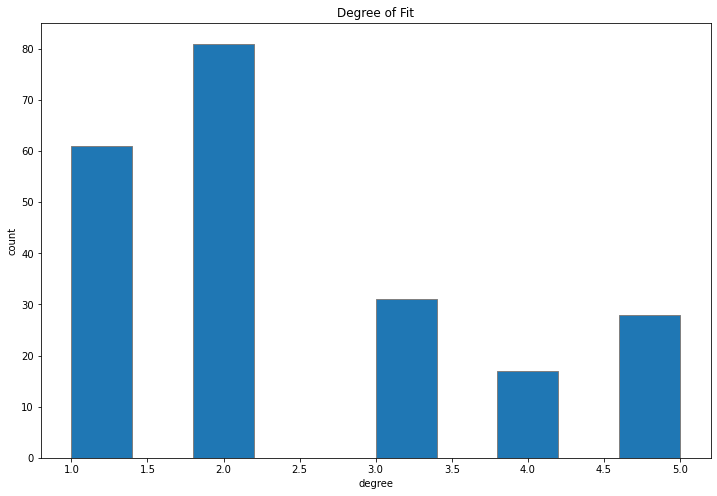

In [39]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(degree_fit, edgecolor='grey')
ax.set(xlabel='degree',ylabel='count',title='Degree of Fit')
plt.show()

One interesting thing to note is that we have several fits that were only linear in nature.  As we mentioned earlier, engines without sufficient data are going to be difficult to fit, because at the beginning of an engines lifespan, the data will appear linear.  

Next, we can merge the metric data into a single dataframe for plotting and analysis purposes. 

In [40]:
red_data = zip(list(df_test['Unit Number'].unique()), degree_fit, final_score, predicted_rul, RUL_list, roots_list)
metric_df = pd.DataFrame(red_data, columns=['Unit Number','Degree','Score','Predicted RUL','Actual RUL','Polynomial Root'])

metric_df

,Unit Number,Degree,Score,Predicted RUL,Actual RUL,Polynomial Root
0,1,3,4645.803348,32.228847,142,86.228847
1,2,5,6.640220,25.565457,52,182.565457
2,3,4,0.336886,33.903430,31,149.903430
3,4,2,640.314265,66.974245,151,140.974245
4,5,1,65.187418,199.497625,254,417.497625
...,...,...,...,...,...,...
213,214,1,4.957311,134.799950,158,309.799950
214,215,5,7.994297,11.444321,40,79.444321
215,216,5,311933.192012,8.542882,173,41.542882
216,217,5,103.415119,32.571132,93,124.571132


Now that we have our metrics dataframe done, let's see what the score looks like for each of the engines.

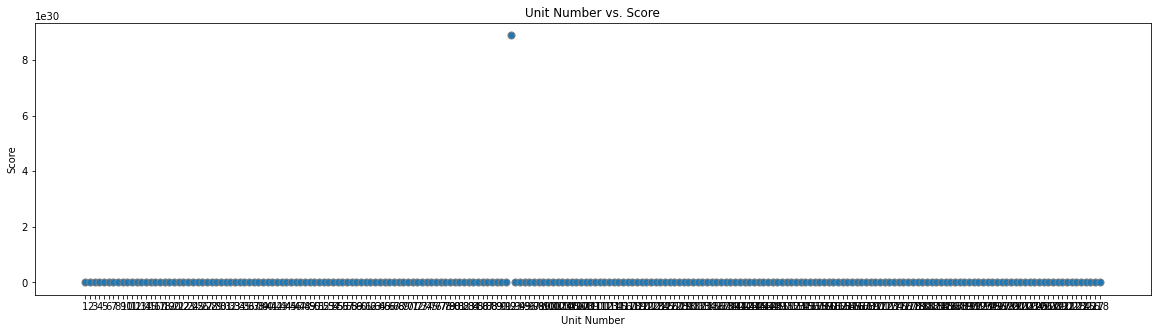

In [41]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
ax.scatter(metric_df['Unit Number'], metric_df['Score'], edgecolor='gray', s=50)
ax.set_xticks(metric_df['Unit Number'])
ax.set(xlabel='Unit Number',ylabel='Score',title='Unit Number vs. Score')
plt.show()

OK, so one prediction did quite bad.  Let's exclude that engine and see if things get better.

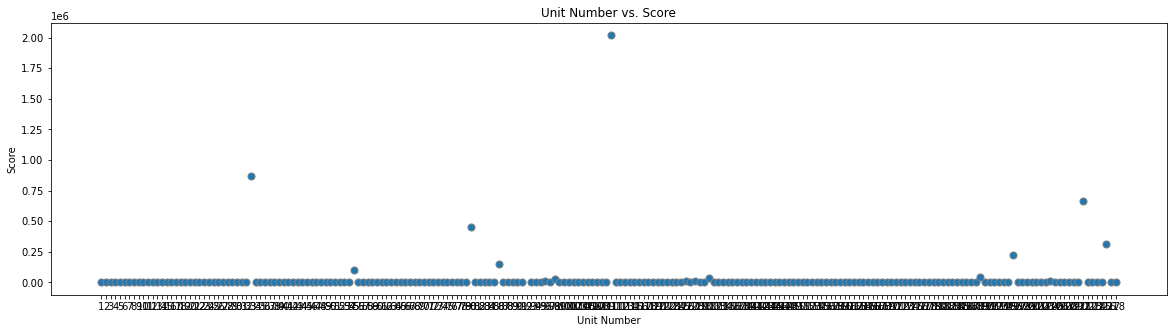

In [42]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
ax.scatter(metric_df[metric_df['Unit Number']!=92]['Unit Number'], metric_df[metric_df['Unit Number']!=92]['Score'], edgecolor='gray', s=50)
ax.set_xticks(metric_df['Unit Number'])
ax.set(xlabel='Unit Number',ylabel='Score',title='Unit Number vs. Score')
plt.show()

Sadly, it doesn't appear that removing that one engine is going to make things better for us with this model.  The variation that is visible in the dots at the bottom indicate that we are just outside of the range needed to see some rather large deviations.  This goes back to our linear fits, as those are certainly going to be poor fits no matter what we do.  

Let's compare the predicted life with the actual life of the engines, as that might give us a better insight into what happened.

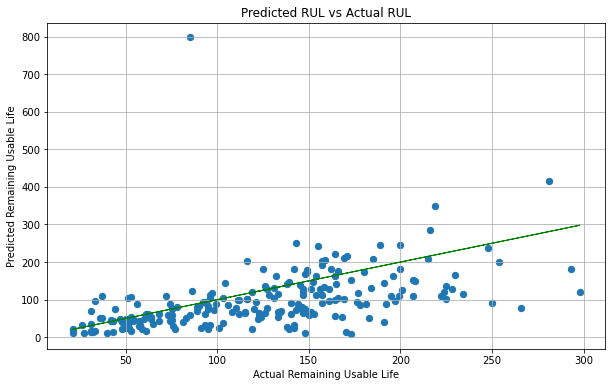

In [43]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(metric_df['Actual RUL'],metric_df['Predicted RUL'], s=40)
ax.grid()
ax.plot(metric_df['Actual RUL'],metric_df['Actual RUL'], c='green',linewidth=1)
ax.set(xlabel='Actual Remaining Usable Life', ylabel='Predicted Remaining Usable Life',title='Predicted RUL vs Actual RUL')
plt.show()

So with that, we have made some predictions for the remaining usable life of some jet engines.  Overall, it's not terrible, but not very good.  While there are multiple approaches that we could have taken for this, linear or polynomial models, like the one used, are fairly straight-forward and could always be made better.  

One of the problems with a model like this is that we are **extrapolating** a significant amount for some of the engines.  If we have insufficient data to extrapolate, then we end up with poor predictions.  Going back to our degree of fit plot earlier, we allowed for linear fits, which will most certainly end poorly.  We could go back and adjust that to ensure we had, at minimum, a cubic fit, which might reduce this problem and make better predictions.  However, it would still be extrapolating a lot.  Really, we just need to find a way to identify where engines appear to start failing and predict from there. 

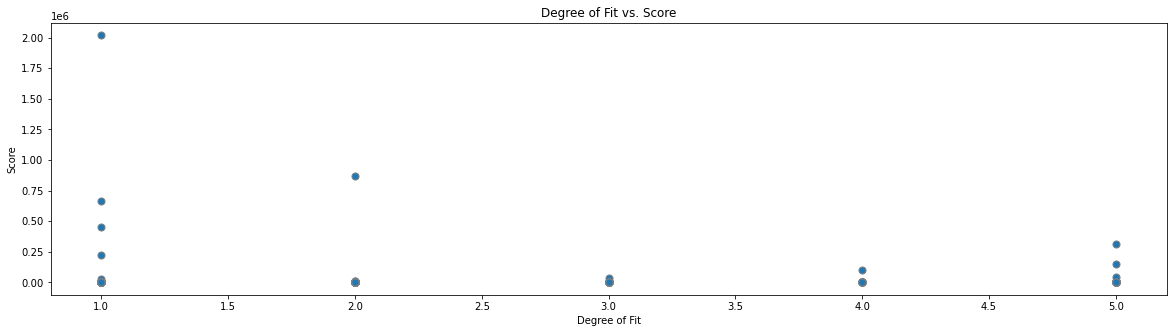

In [45]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
ax.scatter(metric_df[metric_df['Unit Number']!=92]['Degree'], metric_df[metric_df['Unit Number']!=92]['Score'], edgecolor='gray', s=50)
ax.set(xlabel='Degree of Fit',ylabel='Score',title='Degree of Fit vs. Score')
plt.show()

In [51]:
del score
del degrees
del degree_fit
del final_score
del estimated_rul_dict
del roots_dict

degrees = [2,3,4,5,6]
degree_fit = []
final_score=[]
estimated_rul_dict={}
roots_dict={}

for i in df_test['Unit Number'].unique():
    
    uniti = df_test[df_test['Unit Number']==i]
    
    score = np.empty(len(degrees))
    
    estimated_rul_dict[i] = {}
    roots_dict[i] = {}
    
    for d in degrees:
        poly_params = np.polyfit(uniti['Time in Cycles'],uniti['Health1'],d)       
        poly_ = np.poly1d(poly_params)                           
        roots = poly_.r                                                 
        roots = roots[np.isreal(roots)].real                            
        roots = roots[roots>0]                                          
        
        if roots.shape[0]==1:
            pred_rul = roots - max(uniti['Time in Cycles'])                      
            errors = pred_rul - RUL_list[i-1] 
            score[d-2]=scoring_function(errors)
            
            estimated_rul_dict[i][scoring_function(errors).item()] = pred_rul.item()
            roots_dict[i][scoring_function(errors).item()] = roots.item()            
            
        elif roots.shape[0]>1:
            pred_rul = roots[0] - max(uniti['Time in Cycles'])
            errors = pred_rul - RUL_list[i-1]
            score[d-2]=scoring_function(errors)
            
            estimated_rul_dict[i][scoring_function(errors).item()] = pred_rul.item()
            roots_dict[i][scoring_function(errors).item()] = roots[0].item()
        
        else:
            score[d-2]=scoring_function(7000)
        
    
    degree_fit.append(np.argmin(score))
    final_score.append(np.min(score)+2)
    
predicted_rul=[]
for i in estimated_rul_dict.keys():
    predicted_rul.append(estimated_rul_dict[i][min(estimated_rul_dict[i].keys())])
    
roots_list = []
for i in roots_dict.keys():
    roots_list.append(roots_dict[i][min(roots_dict[i].keys())])

<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1
<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1
<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1
<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1
C:\Users\jacob\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-31-e322460d87ca>:3: RuntimeWarning: overflow encountered in exp
  s = np.exp(error/10)-1


ValueError: min() arg is an empty sequence

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(degree_fit, edgecolor='grey')
ax.set(xlabel='degree',ylabel='count',title='Degree of Fit')
plt.show()

In [ ]:
red_data = zip(list(df_test['Unit Number'].unique()), degree_fit, final_score, predicted_rul, RUL_list, roots_list)
metric_df = pd.DataFrame(red_data, columns=['Unit Number','Degree','Score','Predicted RUL','Actual RUL','Polynomial Root'])

metric_df

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(metric_df['Actual RUL'],metric_df['Predicted RUL'], s=40)
ax.grid()
ax.plot(metric_df['Actual RUL'],metric_df['Actual RUL'], c='green',linewidth=1)
ax.set(xlabel='Actual Remaining Usable Life', ylabel='Predicted Remaining Usable Life',title='Predicted RUL vs Actual RUL')
plt.show()

### Poor Models - Principal components

In contrast, there are model choices that *seem* like a good idea, but end up being poor models for this type of problem.  One example, in this case, is Principal Components.  As was mentioned earlier, several of these sensors seem to be measuring the same "thing".  Further, it makes sense that there might be principal components that would indicate the health of a jet engine, given that there are only so many inputs and outputs.  So.... why do I say this is a poor model in this case?  Well, let's take a look.  

We can start here by going back to our large grouping of sensors that were (1) not discrete variables and (2) actually seemed useful.  At this point, this still includes sensor 8, 9, 13, and 14.  As you'll recall, these seemed highly correlated and, therefore, we only kept one pair of them.  

In [16]:
x_pca_in = red_norm_train_df[['SM2','SM3','SM4','SM7','SM8','SM9','SM11','SM12','SM13','SM14','SM15','SM17','SM20','SM21']]
x_pca_in.describe()

,SM2,SM3,SM4,SM7,SM8,SM9,SM11,SM12,SM13,SM14,SM15,SM17,SM20,SM21
count,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04,4.591800e+04
mean,-1.201851e-12,2.032937e-13,-1.206282e-13,3.468986e-13,-1.986665e-11,1.765637e-13,-9.404156e-14,-9.153696e-13,2.571106e-11,-7.922391e-13,3.030395e-13,9.780205e-16,2.186381e-13,8.986800e-14
std,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01,9.999456e-01
min,-3.462595e+00,-3.350048e+00,-3.036529e+00,-4.222277e+00,-2.699726e+00,-2.044901e+00,-2.792504e+00,-3.773548e+00,-2.836666e+00,-2.280972e+00,-3.292945e+00,-3.536666e+00,-3.803847e+00,-4.166545e+00
25%,-7.000744e-01,-6.895970e-01,-7.087195e-01,-6.586278e-01,-6.114623e-01,-5.803541e-01,-7.217952e-01,-6.487058e-01,-6.109358e-01,-5.731239e-01,-7.134891e-01,-7.939168e-01,-6.830357e-01,-6.581114e-01
50%,-5.832952e-02,-5.623612e-02,-9.571446e-02,2.917163e-02,-1.687069e-01,-1.890300e-01,-1.020925e-01,3.487438e-02,-1.502806e-01,-1.704691e-01,-9.089939e-02,-8.443184e-02,2.296167e-02,3.461234e-02
75%,6.395553e-01,6.381764e-01,6.263048e-01,7.023030e-01,3.932286e-01,2.674522e-01,6.071749e-01,6.952923e-01,3.782780e-01,3.085765e-01,6.309794e-01,6.250531e-01,6.986264e-01,6.889569e-01
max,4.075911e+00,4.235689e+00,4.062193e+00,3.797108e+00,9.398807e+00,8.830641e+00,3.713778e+00,4.105300e+00,9.197753e+00,8.890656e+00,3.888250e+00,4.172478e+00,4.198818e+00,3.705914e+00


When we run PCA on this to determine an appropriate number of components, here's what we get.

<IPython.core.display.Javascript object>


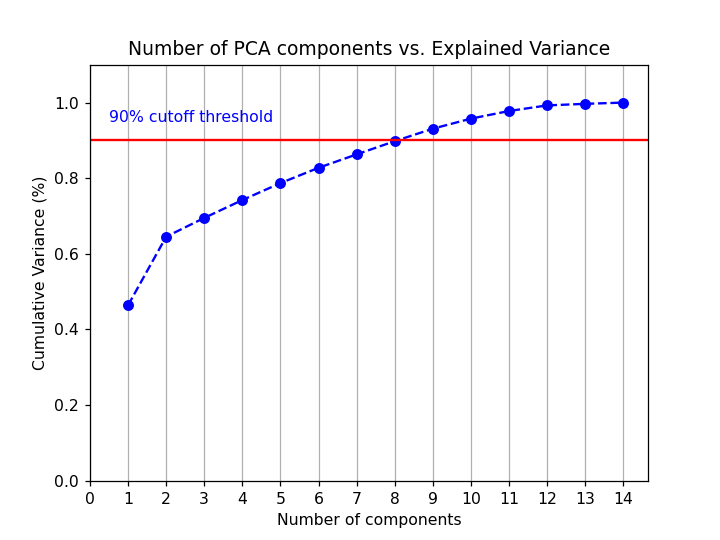

In [19]:
pca = PCA().fit(x_pca_in)

fig, ax = plt.subplots()
xi = np.arange(1,15, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi,y,marker='o', linestyle='--',color='b')
plt.xlabel('Number of components')
plt.xticks(np.arange(0,15,step=1))
plt.ylabel('Cumulative Variance (%)')
plt.title('Number of PCA components vs. Explained Variance')

plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.95, '90% cutoff threshold', color='blue')

ax.grid(axis='x')
plt.show()

If we stick with a 90% threshold, it looks like we need about 8 principal components to explain the variance.  However, following our intuition that there should be only a limited set of "things" that matter for this, we will look at 2 components.  While not explored here, I have gone through the work for 8 components and we end up with very noisy results for components 3-8, so they don't provide a significant amount of benefit other than better modelling noise.

In [20]:
x_pca_in = red_norm_train_df[['SM2','SM3','SM4','SM7','SM8','SM9','SM11','SM12','SM13','SM14','SM15','SM17','SM20','SM21']]

pca = PCA(n_components=2).fit(x_pca_in)

principal_components = pca.fit_transform(x_pca_in)

principal_train_df = pd.DataFrame(data = principal_components, columns = ['PC1','PC2'])
fp_train_df = pd.concat([principal_train_df,red_norm_train_df[['RevCycles','Unit Number']]], axis=1)
fp_train_df.head()

,PC1,PC2,RevCycles,Unit Number
0,-2.943715,-0.180131,-222,1
1,-3.213017,0.319781,-221,1
2,-1.403975,-0.486647,-220,1
3,-2.267658,-0.691777,-219,1
4,-2.964554,0.313793,-218,1


So, what does this look like for the first principal component...

<IPython.core.display.Javascript object>


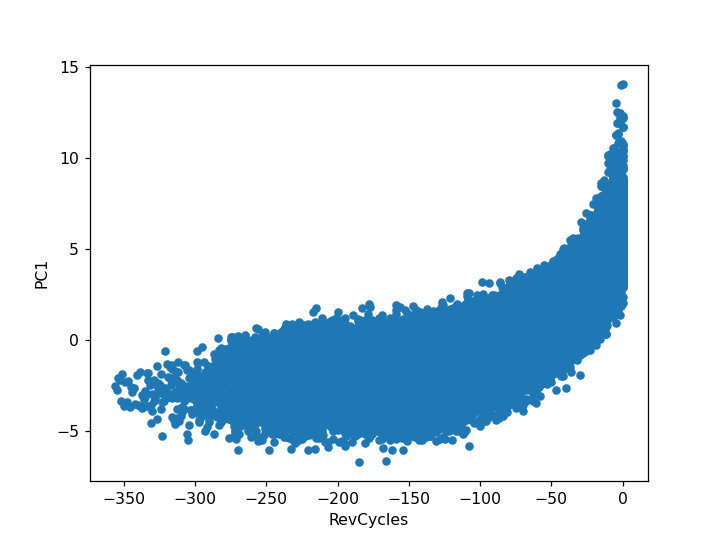

<AxesSubplot:xlabel='RevCycles', ylabel='PC1'>

In [21]:
sensor = 'PC1'
fp_train_df.plot(kind = 'scatter', x='RevCycles', y=sensor)

OK, we are going to stop here.  If we compare this graph with the ones we saw earlier for sensors 13 and 14, this looks *very* similar.  So, Principal Components did it's job, but it extracted those sensors that seemed to have the largest change.  This should make sense intuitively, but if we were going to continue with this approach, we would effectively be doing the same as the linear model, but with only one sensor.  Obviously, this would be a poor choice.